In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install unrar
!unrar x '/content/drive/MyDrive/Model 2.rar' > /dev/null 2>&1

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision import models
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torchvision import datasets
from torchsummary import summary
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
from glob import glob

%matplotlib inline

In [ ]:
data_dir = "/content/Model 2"

def load_data(data_dir):
    train_dir = os.path.join(data_dir, "train")
    valid_dir = os.path.join(data_dir, "valid")
    return train_dir, valid_dir

def explore_data(train_dir):
    data = datasets.ImageFolder(train_dir)
    classes = data.classes

    plants = set()
    num_diseases = 0
    for disease in classes:
        split_idx = disease.find('_')
        if split_idx == -1:
            print(f"Skipping: Cannot unpack '{disease}' into plant and condition. Check disease name.")
            continue

        plant = disease[:split_idx]
        condition = disease[split_idx+1:]
        plants.add(plant)
        if condition.lower() != 'healthy':
            num_diseases += 1

    img_per_class = {disease: len(os.listdir(os.path.join(train_dir, disease))) for disease in classes}

    return classes, img_per_class

In [ ]:
def resize_image(image_path, output_size=(256, 256)):
    with Image.open(image_path) as img:
        img_resized = img.resize(output_size, Image.LANCZOS)
        img_resized.save(image_path)

def resize_images_in_directory(directory, output_size=(256, 256)):
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                file_path = os.path.join(root, file)
                resize_image(file_path, output_size)

main_directory = "/content/Model 2"

subdirectories = ['train', 'valid', 'test']

for subdir in subdirectories:
    full_path = os.path.join(main_directory, subdir)
    resize_images_in_directory(full_path)


In [ ]:
BATCH_SIZE = 32
RANDOM_SEED = 7

In [ ]:
train_dir, valid_dir = load_data(data_dir)
diseases, img_per_class = explore_data(train_dir)

train = ImageFolder(train_dir, transform=transforms.ToTensor())
valid = ImageFolder(valid_dir, transform=transforms.ToTensor())

In [ ]:
img, label = train[0]
print(img.shape, label)

torch.Size([3, 256, 256]) 0


In [ ]:
def show_image(image, label, class_names):
    print(f"Label: {class_names[label]} ({label})")
    plt.imshow(image.permute(1, 2, 0))
    plt.show()

Label: Apple_Black_Rot (0)


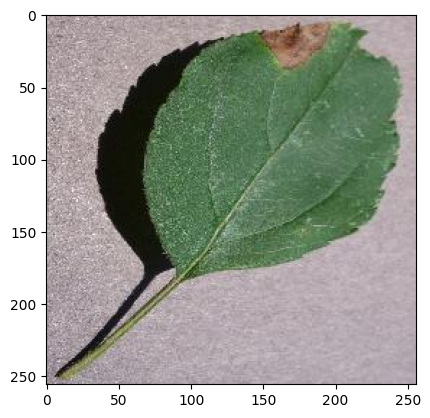

In [ ]:
show_image(*train[0], train.classes)

In [ ]:
torch.manual_seed(RANDOM_SEED)

In [ ]:
train_dl = DataLoader(train, BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid, BATCH_SIZE, num_workers=2, pin_memory=True)

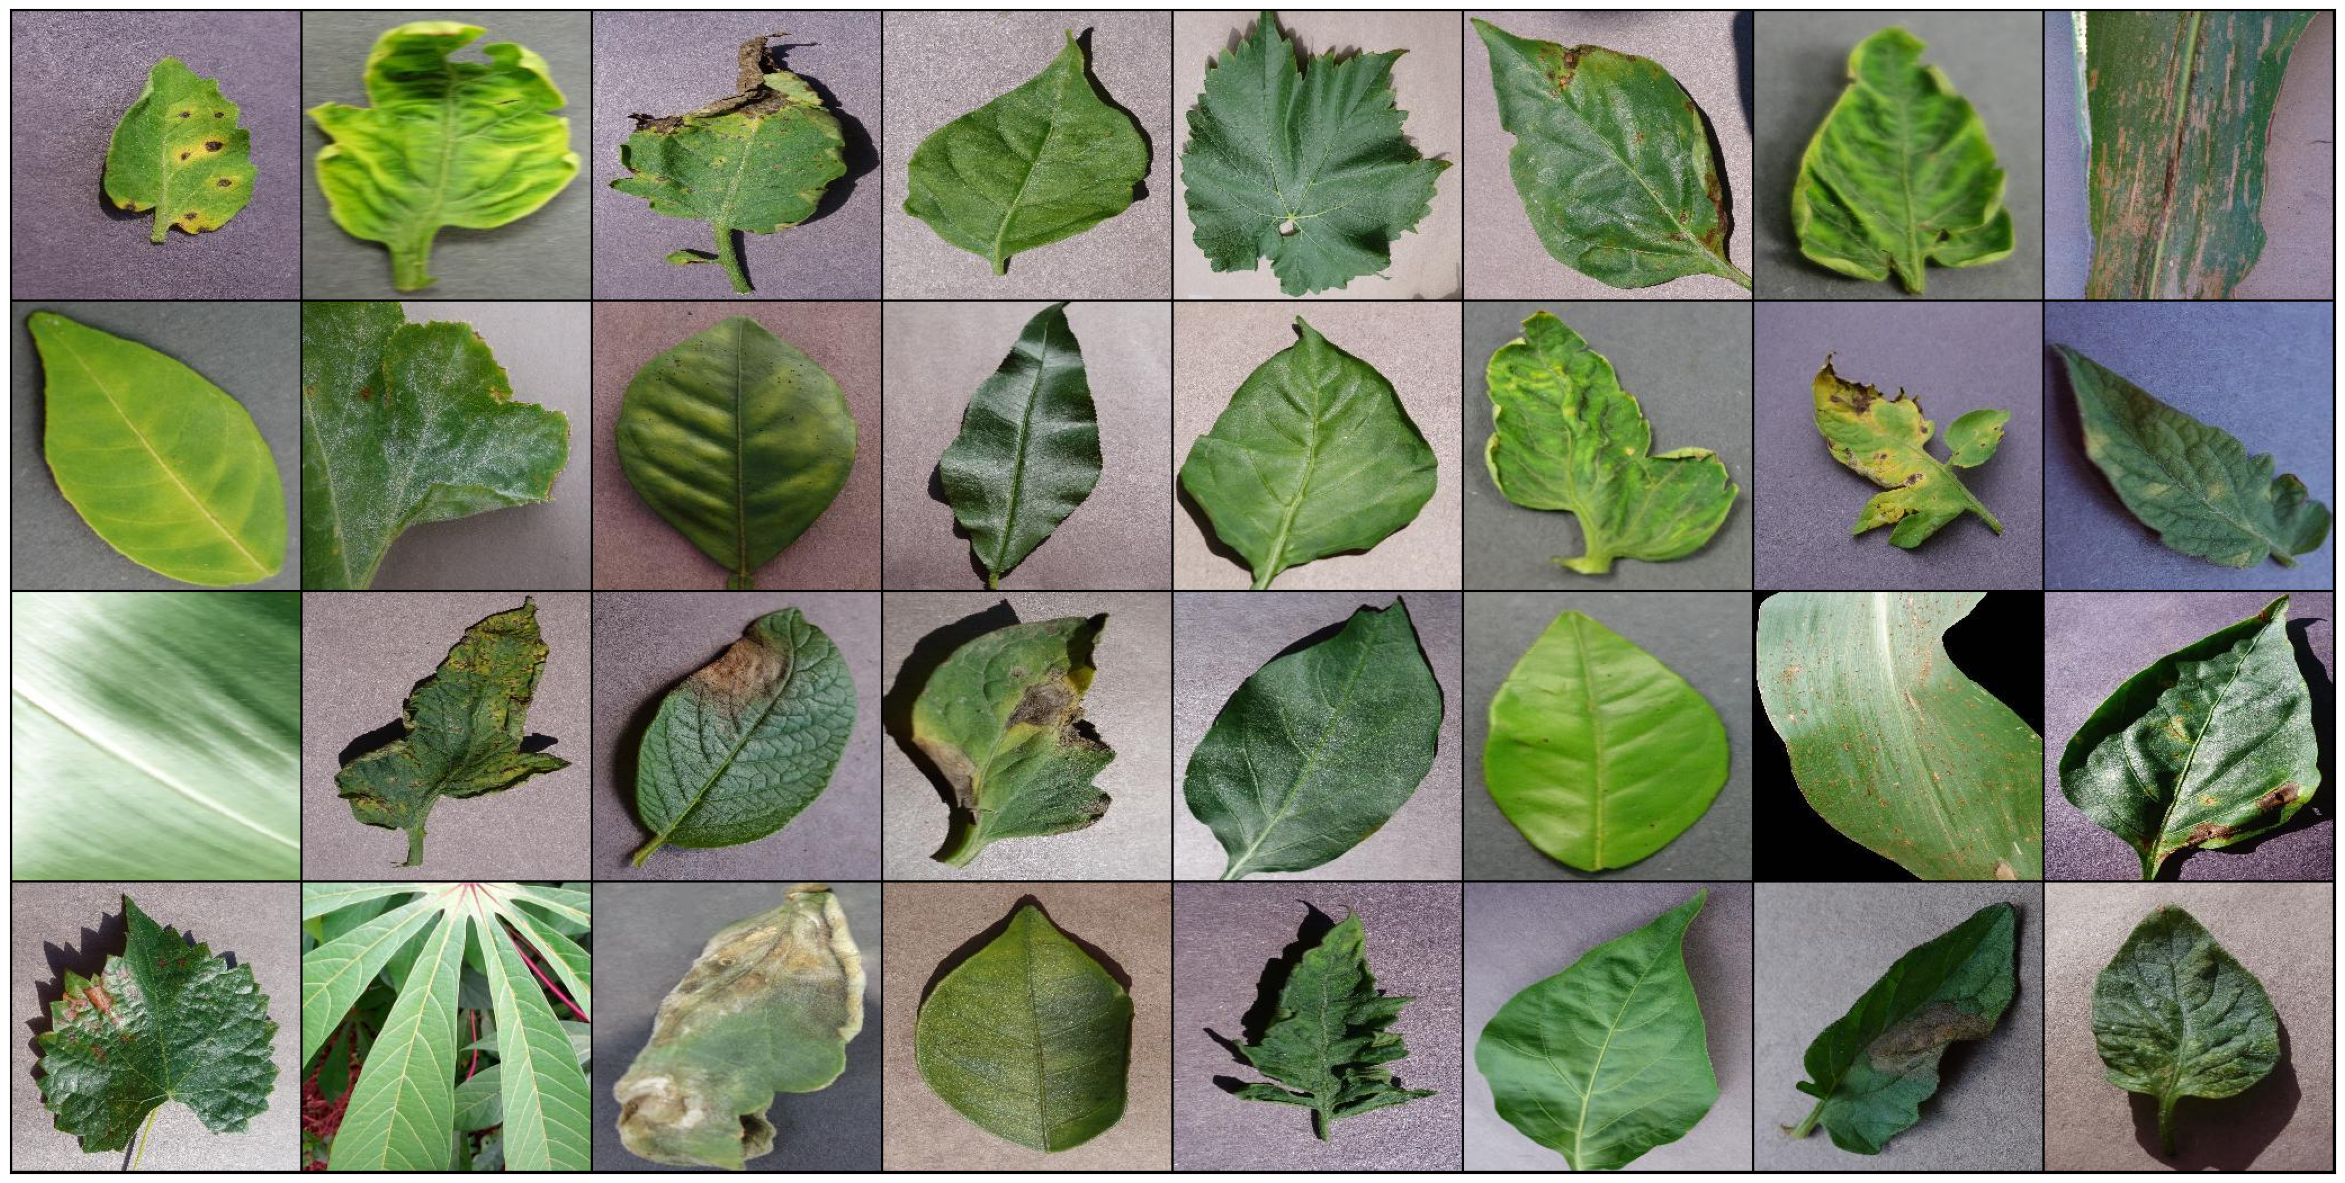

In [ ]:
def show_batch(data):
    for images, labels in data:
        fig, ax = plt.subplots(figsize=(30, 30))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

show_batch(train_dl)

In [ ]:
def get_default_device():
    return torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [ ]:
device = get_default_device()

train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [ ]:
INPUT_SHAPE = (3, 256, 256)
EPOCHS = 10
MAX_LR = 0.01
GRAD_CLIP = 0.1
WEIGHT_DECAY = 1e-4
OPT_FUNC = torch.optim.Adam

In [ ]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, pool=False):
        super(ConvBlock, self).__init__()
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                  nn.BatchNorm2d(out_channels),
                  nn.ReLU(inplace=True)]
        if pool:
            layers.append(nn.MaxPool2d(4))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {"val_loss": loss.detach(), "val_accuracy": acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        batch_accuracy = [x["val_accuracy"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']))

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_diseases):
        super().__init__()

        self.conv1 = ConvBlock(in_channels, 64)
        self.conv2 = ConvBlock(64, 128, pool=True)
        self.res1 = nn.Sequential(ConvBlock(128, 128), ConvBlock(128, 128))

        self.conv3 = ConvBlock(128, 256, pool=True)
        self.conv4 = ConvBlock(256, 512, pool=True)
        self.res2 = nn.Sequential(ConvBlock(512, 512), ConvBlock(512, 512))

        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                       nn.Flatten(),
                                       nn.Linear(512, num_diseases))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
model = ResNet9(3, len(train.classes))
model = model.to(device)
print(summary(model, INPUT_SHAPE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
         ConvBlock-4         [-1, 64, 256, 256]               0
            Conv2d-5        [-1, 128, 256, 256]          73,856
       BatchNorm2d-6        [-1, 128, 256, 256]             256
              ReLU-7        [-1, 128, 256, 256]               0
         MaxPool2d-8          [-1, 128, 64, 64]               0
         ConvBlock-9          [-1, 128, 64, 64]               0
           Conv2d-10          [-1, 128, 64, 64]         147,584
      BatchNorm2d-11          [-1, 128, 64, 64]             256
             ReLU-12          [-1, 128, 64, 64]               0
        ConvBlock-13          [-1, 128, 64, 64]               0
           Conv2d-14          [-1, 128,

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_OneCycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0,
                grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))


    for epoch in range(epochs):
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            lrs.append(get_lr(optimizer))
            sched.step()

        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_accuracy'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'].cpu().numpy() for x in history]

    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

In [ ]:
%%time
history = [evaluate(model, valid_dl)]

CPU times: user 26.3 s, sys: 2.31 s, total: 28.6 s
Wall time: 43.5 s


In [ ]:
%%time
history += fit_OneCycle(EPOCHS, MAX_LR, model, train_dl, valid_dl,
                        grad_clip=GRAD_CLIP,
                        weight_decay=WEIGHT_DECAY,
                        opt_func=OPT_FUNC)

Epoch [0], last_lr: 0.00280, train_loss: 0.8608, val_loss: 2.2759, val_acc: 0.5527
Epoch [1], last_lr: 0.00760, train_loss: 0.5623, val_loss: 0.7008, val_acc: 0.7838
Epoch [2], last_lr: 0.01000, train_loss: 0.4340, val_loss: 0.6314, val_acc: 0.7949
Epoch [3], last_lr: 0.00950, train_loss: 0.3787, val_loss: 0.8927, val_acc: 0.7516
Epoch [4], last_lr: 0.00812, train_loss: 0.3224, val_loss: 0.5738, val_acc: 0.8218
Epoch [5], last_lr: 0.00611, train_loss: 0.2488, val_loss: 0.4584, val_acc: 0.8594
Epoch [6], last_lr: 0.00389, train_loss: 0.1867, val_loss: 0.2472, val_acc: 0.9144
Epoch [7], last_lr: 0.00188, train_loss: 0.1287, val_loss: 0.1326, val_acc: 0.9535
Epoch [8], last_lr: 0.00050, train_loss: 0.0761, val_loss: 0.1033, val_acc: 0.9635
Epoch [9], last_lr: 0.00000, train_loss: 0.0483, val_loss: 0.0925, val_acc: 0.9680
CPU times: user 47min 8s, sys: 43min 58s, total: 1h 31min 6s
Wall time: 1h 36min


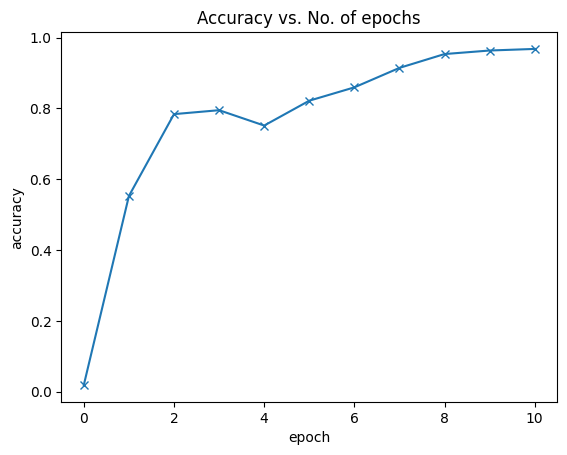

In [ ]:
plot_accuracies(history)

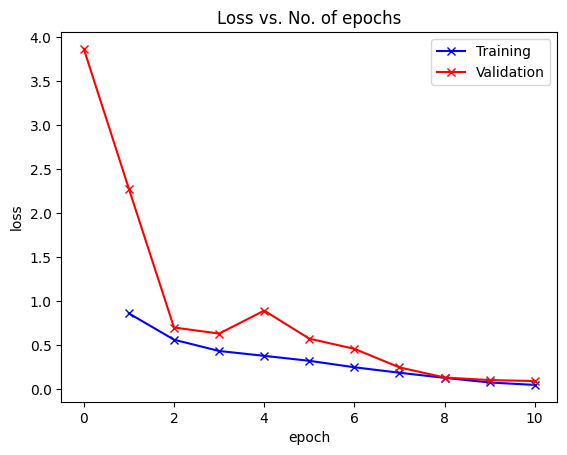

In [ ]:
plot_losses(history)

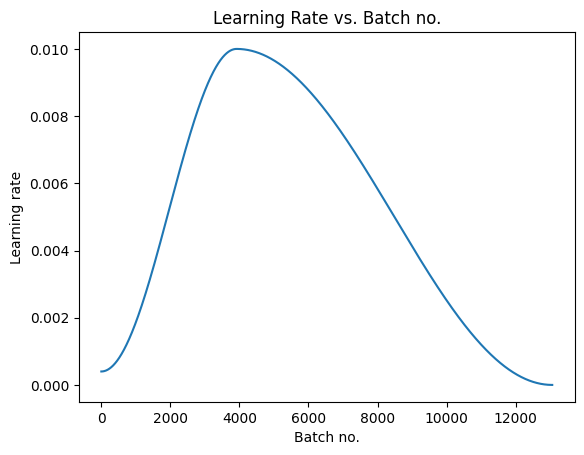

In [ ]:
plot_lrs(history)

In [ ]:
test_dir = "/content/Model 2/test"

In [ ]:
def load_test_data(test_dir):
    """Load and return test dataset."""
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    return ImageFolder(test_dir, transform=transform)

def predict_image(img, model, classes):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return classes[preds[0].item()]

def display_prediction(img, label, model, classes):
    """Display image and model prediction."""
    plt.imshow(img.permute(1, 2, 0))
    print('Label:', label, ', Predicted:', predict_image(img, model, classes))

def predict_all_images(test_data, model):
    """Predict and print labels for all images in test dataset."""
    for i, (img, _) in enumerate(test_data):
        label = test_images[i]
        predicted = predict_image(img, model, test_data.classes)
        print('Label:', label, ', Predicted:', predicted)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

for img_name in os.listdir(test_dir):
    img_path = os.path.join(test_dir, img_name)
    img = Image.open(img_path).convert("RGB")

    img_t = transform(img)
    img_t = img_t.to(device)[None, ...]

    with torch.no_grad():
        outputs = model(img_t)
        _, predicted = torch.max(outputs, 1)
        class_name = train.classes[predicted.item()]

    plt.imshow(img)
    plt.title(f'Predicted: {class_name}')
    plt.ylabel(f'Actual: {img_name}')
    plt.show()

In [ ]:
# In separate Results folder